In [1]:
import numpy as np 
import torch

import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration

from util import *

In [2]:
# on the cblgpu08 computer

# different methods
checkpoints = [('run-20210514_191847-3u588wxi', 'NC Ens 3, reg 0.5'), ('run-20210514_192309-2rlfhitc', 'Ens 3'),
('run-20210514_192736-3q5el7rl', 'MC drop 3, rate 0.5'), ('run-20210514_193101-nyehd80r', 'Single')]

# different NC weight
# checkpoints = [('run-20210514_191847-3u588wxi', 'NCEns 3, reg 0.5'), ('run-20210514_223116-3tusc1ni', 'NCEns 3, reg 0.1'),
# ('run-20210514_223603-1ogek1sb', 'NCEns 3, reg 0.3'), ('run-20210514_224048-14iqxlw4', 'NCEns 3, reg 0.7'),
# ('run-20210514_224531-375asb5u', 'NCEns 3, reg 1'), ('run-20210514_225017-aiy9lfbx', 'NCEns 3, reg 2')] 

In [3]:
# for MNIST
checkpoint_epoch = 20
corruption_intensity = 60
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    checkpointed_args = f'/scratch/gp491/wandb/checkpoints/{run_id}/args.json'
    checkpointed_model = f'/scratch/gp491/wandb/checkpoints/{run_id}/epoch_{checkpoint_epoch}.pth'

    model_args = Configuration.from_json(checkpointed_args)
    trainer = get_trainer(model_args, device='cpu')
    trainer.load_checkpoint(checkpointed_model)

    test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=corruption_intensity, corruption='rotation')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

Initialising a negative-correlation normalised ensemble of 3 networks
  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:200: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  0%|          | 0/79 [00:00<?, ?batch/s]Results: 
Accuracy: 0.2292
NLL: 3.3992810607910156
ECE: 0.47811771217733623
Brier: 1.1462692761421203
Initialising an ensemble of 3 networks


In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy vs Confidence. Rotation, intensity 4')

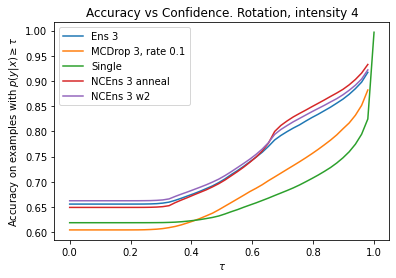

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Rotation, intensity {corruption_intensity}')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Rotation, intensity {corruption_intensity}')

Text(0.5, 1.0, 'Count vs Confidence. Rotation, intensity 4')

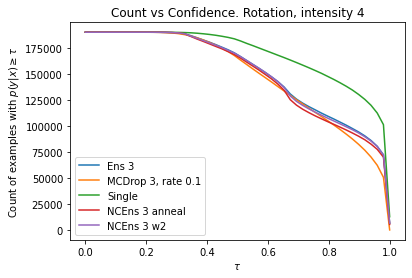

Ens 3
55104.0
MCDrop 3, rate 0.1
28967.0
Single
78220.0
NCEns 3 anneal
54102.0
NCEns 3 w2
55789.0


Text(0.5, 1.0, 'Count vs Entropy. Rotation, intensity 4')

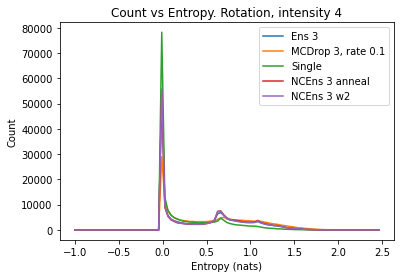

In [8]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Rotation, intensity {corruption_intensity}')

## OOD Data

In [4]:
import torchvision

In [17]:
# for CIFAR
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100) # since only entropy really makes sense

res_ood = []

for run_id, name in checkpoints:

    checkpointed_args = f'/scratch/gp491/wandb/checkpoints/{run_id}/args.json'
    checkpointed_model = f'/scratch/gp491/wandb/checkpoints/{run_id}/epoch_{checkpoint_epoch}.pth'

    model_args = Configuration.from_json(checkpointed_args)
    trainer = get_trainer(model_args, device='cpu')
    trainer.load_checkpoint(checkpointed_model)

    test_set = torchvision.datasets.FashionMNIST(root=constants.DATA_DIR, split='train', download=True, transform=torchvision.transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res_ood.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

Initialising an ensemble of 3 networks
SGD optimizer


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?batch/s]/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:230: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  0%|          | 1/573 [00:00<01:19,  7.20batch/s]
Testing
100%|██████████| 573/573 [01:12<00:00,  7.94batch/s]
Results: 
Accuracy: 0.10793507787651692
NLL: 5.453151104740108
ECE: 0.4080395604956672
Brier: 1.1790135065900027
SGD optimizer
using multistep sched

Ens 3
7029.0
MCDrop 3, rate 0.1
5670.0
Single
6103.0
NCEns 3 anneal
6527.0
NCEns 3 w2
7996.0


Text(0.5, 1.0, 'Count vs Entropy. OOD dataset.')

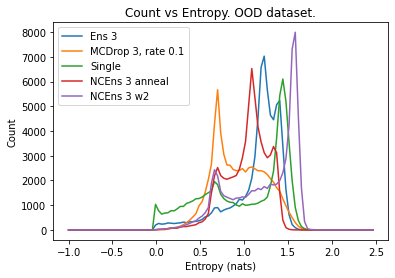

In [20]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. OOD dataset.')

Text(0.5, 1.0, 'Count vs Confidence. OOD Data')

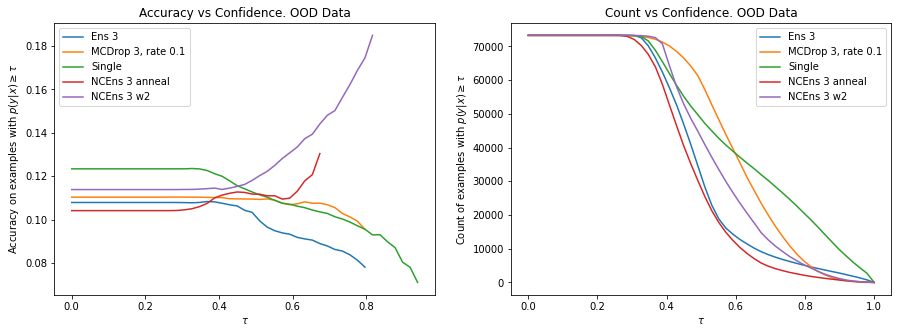

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. OOD Data')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. OOD Data')

In [16]:
print(res_ood[0][3])

[0.10172096 0.10172096 0.10172096 0.10172096 0.10172096 0.10172096
 0.10172096 0.10172096 0.10172096 0.10172096 0.10172096 0.10172096
 0.10172096 0.10172487 0.1017405  0.10165776 0.10086523 0.10112223
 0.10106771 0.10138249 0.10119854 0.10127283 0.10041789 0.09914542
 0.09802723 0.09410191 0.09192491 0.08960221 0.09020875 0.08988095
 0.08784017        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
